In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

simulation_data = Path.home()/'group'/'project'/'datasets'/'data'/'211116_grad_b_est.h5'

def dumb_interpolator(array):
    
    interpolated_array = np.copy(array)
    temp_array = np.copy(array)
    
    zeros_init = np.argwhere(array==0.)
    #print(zeros_init)
    
    neighborinds = [
        [1,1],
        [0,1],
        [-1,1],
        [-1,0],
        [-1,-1],
        [0,-1],
        [0,0],
        [1,0],
        #[2,0],
        #[2,1],
        #[2,2],
        #[1,2],
        #[0,2],
        #[-1,2],
        #[-2,2],
        #[-2,1],
        #[-2,0],
        #[-2,-1],
        #[-2,-2],
        #[-1,-2],
        #[0,-2],
        #[1,-2],
        #[2,-2],
        #[2,-1]
    ]
    
    n_passes = 3
    
    for k in range(n_passes):
    
        for i in range(zeros_init.shape[0]):
            zeros = np.argwhere(array==0.)
            neighbors = []
            for j, inds in enumerate(neighborinds):
                try:
                    if array[zeros[0,0]+inds[0], zeros[0,1]+inds[1]] > 0:
                        neighbors.append(
                            temp_array[zeros[i,0]+inds[0], zeros[i,1]+inds[1]]
                        )
                except:
                    pass
            interpolated_array[zeros_init[i,0],zeros_init[i,1]] = np.mean(neighbors)
            
            temp_array = interpolated_array
        
    return interpolated_array


In [2]:
file = h5py.File(simulation_data, 'r')

In [3]:
print(file.keys())

<KeysViewHDF5 ['data', 'meta']>


In [4]:
print(file['meta']['theta_max'][:].min(), file['meta']['theta_max'][:].max())
print(file['meta']['x_max'][:].min(), file['meta']['x_max'][:].max())

84.0 90.0
0.0 0.05


In [5]:
print(file['data'].shape)

#data = file['data'][:].reshape((60,8192))[:, 0:256]

(6070, 491520)


In [6]:
pitch_angles = file['meta']['theta_max'][:]
r_position = file['meta']['x_max'][:]

r_grid, p_grid = np.meshgrid(np.sort(np.unique(r_position)), np.sort(np.unique(pitch_angles)))

In [8]:
v_sum_square_grid = np.zeros(r_grid.size)

for i, pair in enumerate(zip(r_grid.flatten(), p_grid.flatten())):
    radius_match = r_position == pair[0] # where the data matches the r grid 
    pitch_match = pitch_angles == pair[1] # where the data matches the p grid
    both_match = radius_match * pitch_match 
    
    if both_match.sum() == 1:
        temp_data = file['data'][np.argwhere(both_match).squeeze(), :]
        
        v_sum_square_grid[i] = abs(np.vdot(temp_data, temp_data))
    else:
        pass
    if i%100 == 99:
        print(i+1)
        
v_sum_square_grid = v_sum_square_grid.reshape((r_grid.shape))
    

100
200
300
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100


In [7]:
#np.save(
#    Path.home()/'group'/'project'/'datasets'/'data'/'230214_grad_b_est_v_sum_square_grid',
#    v_sum_square_grid
#)

v_sum_square_grid = np.load(
    Path.home()/'group'/'project'/'datasets'/'data'/'230214_grad_b_est_v_sum_square_grid.npy',
)


In [8]:
print(v_sum_square_grid.shape)

(121, 51)


In [9]:
interp_v_sum_square_grid = dumb_interpolator(v_sum_square_grid[:, 0:50])

In [10]:
sns.set_theme(context='talk', style='ticks', font_scale=1.2)

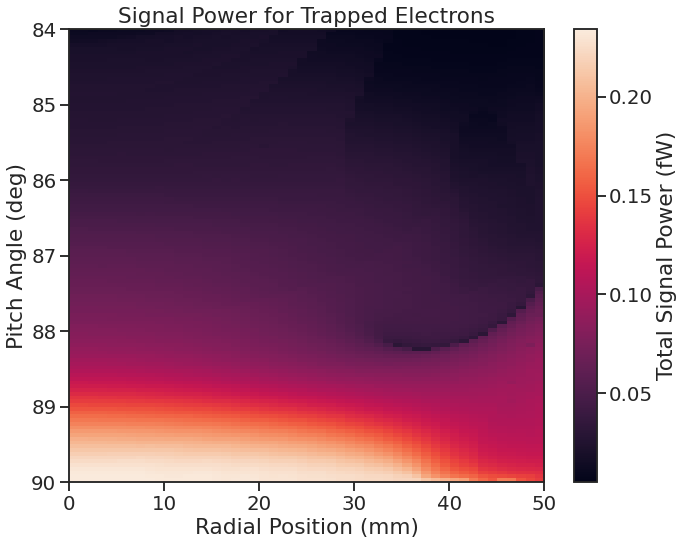

In [16]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

cmap = sns.color_palette('rocket', as_cmap=True)

img = ax.imshow(
    interp_v_sum_square_grid[:, 0:50] / (8192*50*1e-15),
    #10*np.log10((interp_v_sum_square_grid / (8192*50))/1e-15),
    cmap=cmap,
    aspect='auto',
    extent=(0,49, 90,84), 
    interpolation='nearest'
)

ax.set_xticks(np.linspace(0,49,6))
ax.set_xticklabels(np.arange(0,60,10))
ax.set_xlabel('Radial Position (mm)')
ax.set_ylabel('Pitch Angle (deg)')

cbar = fig.colorbar(img, label='Total Signal Power (fW)')
ax.set_title('Signal Power for Trapped Electrons')
plt.tight_layout(pad=1.05)

plt.savefig(Path.home()/'group'/'project'/'plots'/'230215_signal_power_by_pitch_and_radius_femptowatts', dpi=144)

In [17]:
np.max(interp_v_sum_square_grid[:, 0:50] / (8192*50*1e-15))


0.23404021776141093